
Data Summary Table:
                     count          mean            std        min        25%  \
Payment_History       18.0  8.011111e+01      13.163626      58.00      70.75   
Credit_Utilization    18.0  3.761111e+01      15.282204      13.00      28.00   
Credit_Mix            18.0  1.555556e+00       0.511310       1.00       1.00   
Credit_Age            18.0  5.944444e+00       3.438061       1.00       3.00   
Inquiries             18.0  2.555556e+00       1.916560       0.00       1.00   
Utility_Bill          18.0  7.222222e-01       0.460889       0.00       0.25   
Mobile_Bill           18.0  7.777778e-01       0.427793       0.00       1.00   
Annual_Income         18.0  1.113333e+06  595996.446890  350000.00  650000.00   
Loan_Amount           18.0  1.763889e+05   61304.580856   80000.00  120000.00   
Num_Loans             18.0  2.611111e+00       1.195033       1.00       2.00   
Num_Credit_Cards      18.0  2.611111e+00       1.539247       1.00       1.25   
EMI_Mis

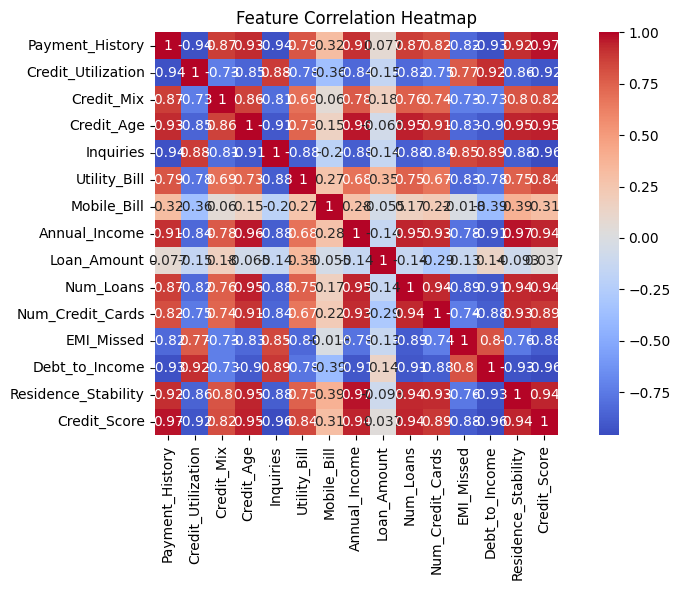

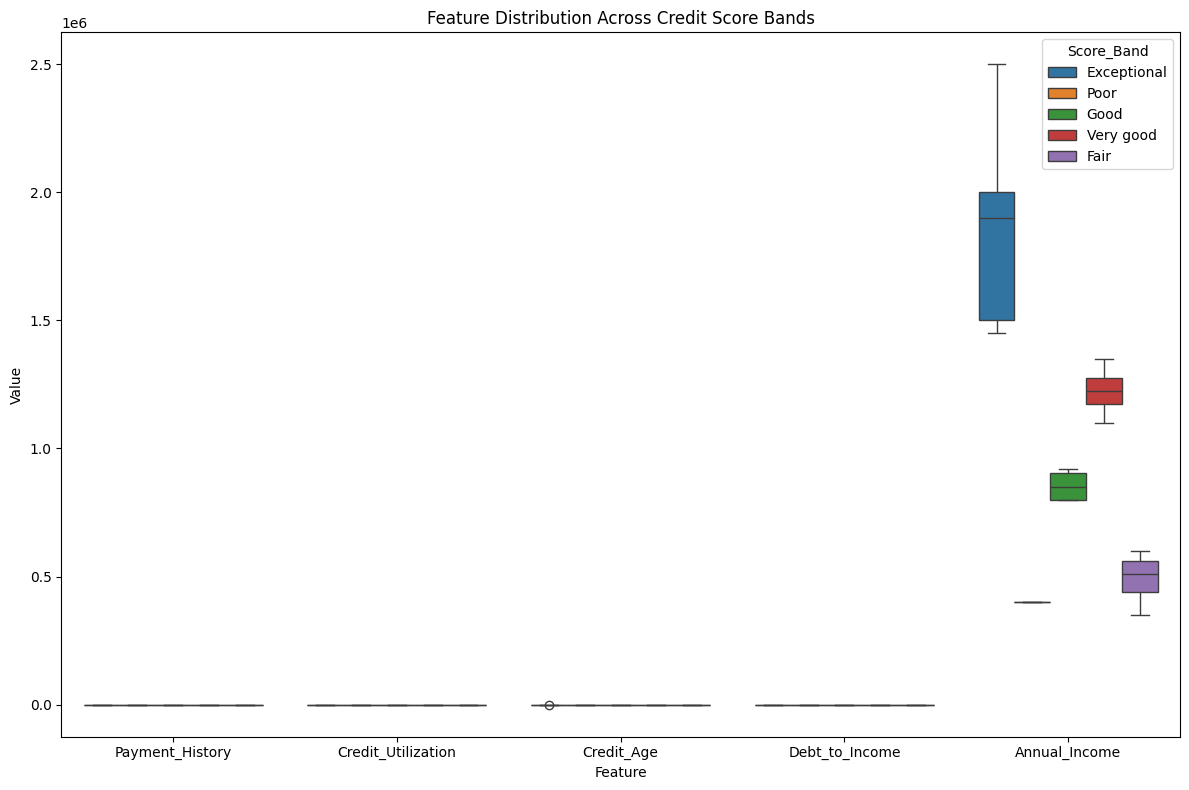

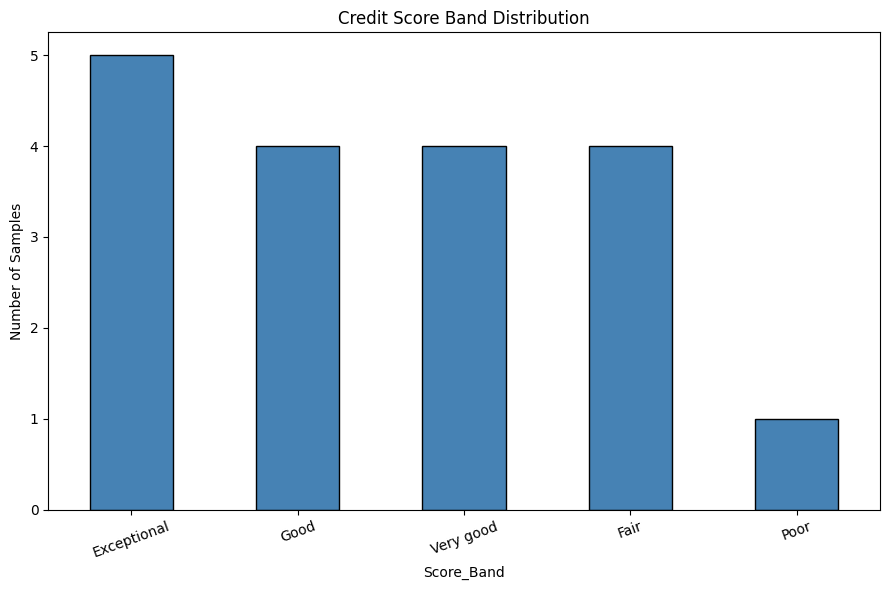

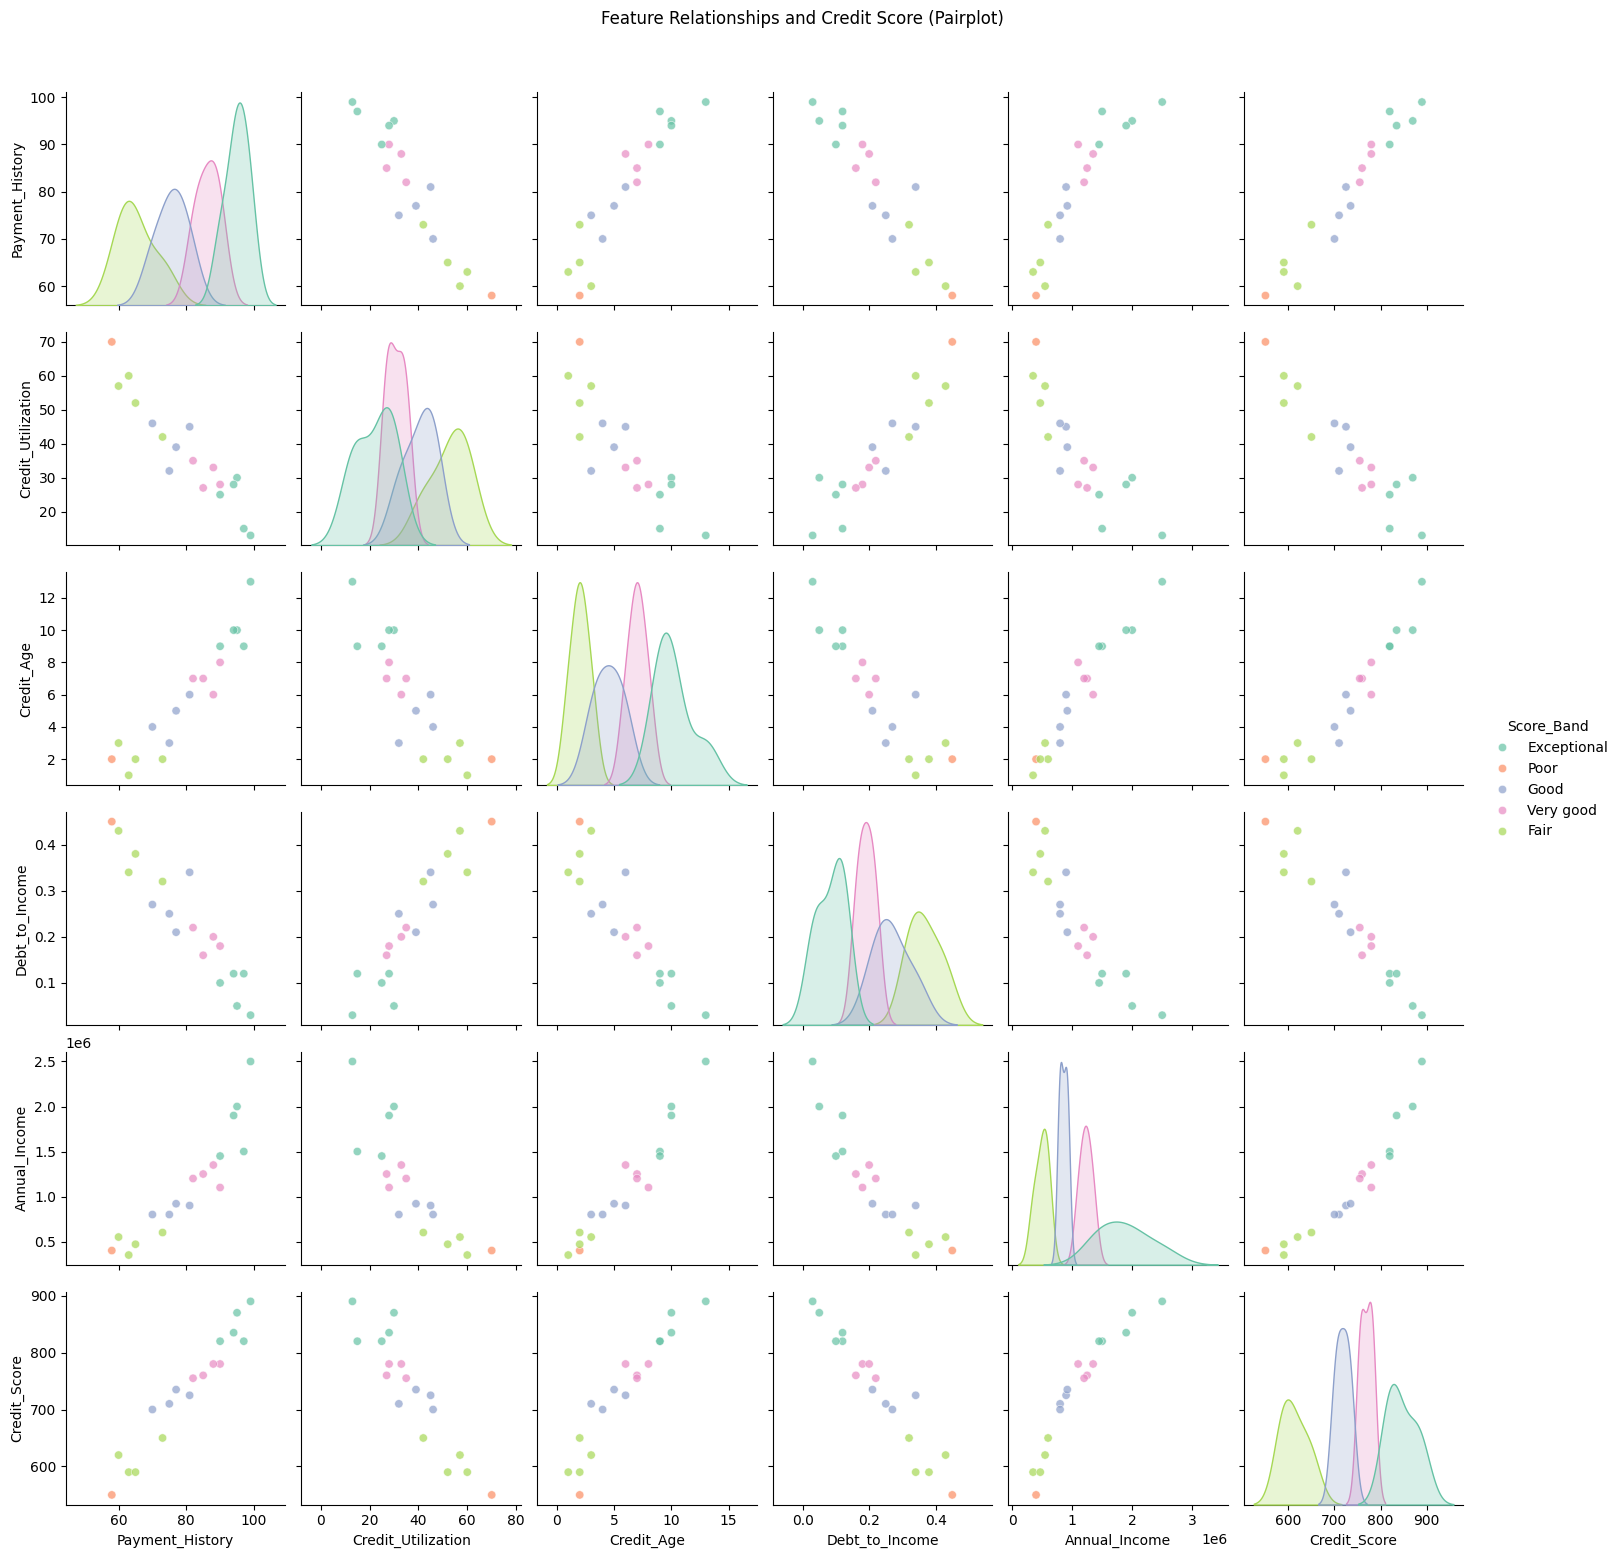


Model Performance Metrics:
  R^2 Score (Accuracy): 0.92
  Cross-validated mean R^2 Score: 0.95


<Figure size 900x600 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error


df = pd.read_csv('enhanced_credit_data_.csv')
numeric_cols = ['Annual_Income', 'Loan_Amount', 'Debt_to_Income']
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)


def score_band(score):
    if score >= 800:
        return 'Exceptional'
    elif score >= 740:
        return 'Very good'
    elif score >= 670:
        return 'Good'
    elif score >= 580:
        return 'Fair'
    else:
        return 'Poor'
df['Score_Band'] = df['Credit_Score'].apply(score_band)


print("\nData Summary Table:")
print(df.describe().T)


plt.rcParams['figure.figsize'] = (9,6)


corr = df.select_dtypes(include=np.number).corr()
plt.figure()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,8))
selected_features = ['Payment_History', 'Credit_Utilization', 'Credit_Age', 'Debt_to_Income', 'Annual_Income']
melted_df = df.melt(id_vars=['Score_Band'], value_vars=selected_features,
                    var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='Score_Band', data=melted_df)
plt.title('Feature Distribution Across Credit Score Bands')
plt.tight_layout()
plt.show()


plt.figure()
ax = df['Score_Band'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Credit Score Band Distribution')
plt.ylabel('Number of Samples')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


sns.pairplot(df,
             vars=selected_features + ['Credit_Score'],
             hue='Score_Band',
             palette='Set2',
             plot_kws={'alpha':0.7})
plt.suptitle('Feature Relationships and Credit Score (Pairplot)', y=1.04)
plt.show()


X = df.drop(['Credit_Score', 'Score_Band'], axis=1)
y = df['Credit_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
gb = GradientBoostingRegressor(random_state=42)
gs = GridSearchCV(gb, param_grid, cv=5, scoring='r2')
gs.fit(X_train, y_train)
best_gb = gs.best_estimator_

preds = best_gb.predict(X_test)
feat_imp = pd.Series(best_gb.feature_importances_, index=X.columns).sort_values(ascending=True)

acc = best_gb.score(X_test, y_test)
mse = mean_squared_error(y_test, preds)
cv_scores = cross_val_score(best_gb, X_scaled, y, cv=5, scoring='r2')
print(f"\nModel Performance Metrics:")
print(f"  R^2 Score (Accuracy): {acc:.2f}")
print(f"  Cross-validated mean R^2 Score: {np.mean(cv_scores):.2f}")



plt.tight_layout()
plt.show()



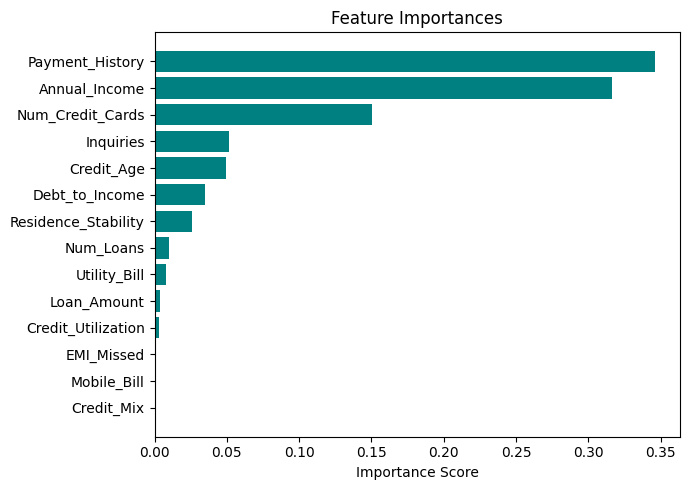

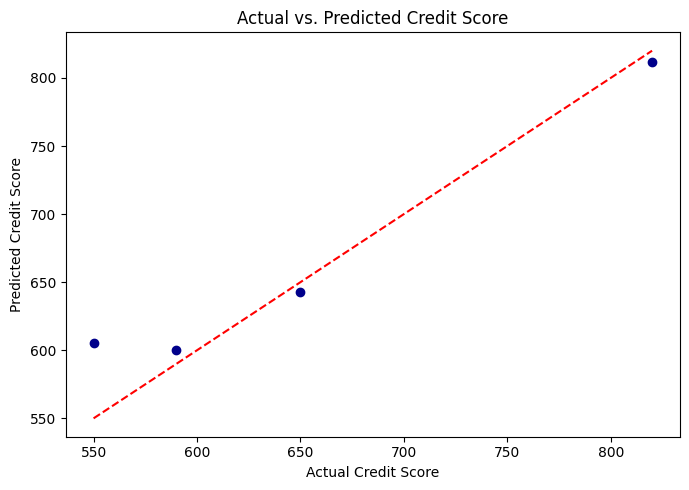

In [ ]:
import matplotlib.pyplot as plt

# Feature Importances plot
plt.figure(figsize=(7, 5))
plt.barh(feat_imp.index, feat_imp.values, color='teal')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(7, 5))
plt.scatter(y_test, preds, color='darkblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs. Predicted Credit Score')
plt.xlabel('Actual Credit Score')
plt.ylabel('Predicted Credit Score')
plt.tight_layout()
plt.show()